In [1]:
import fitbit
from fitbit import gather_keys_oauth2 as Oauth2
import pandas as pd 
import datetime
from dateutil.parser import parse
from matplotlib import pyplot as plt

CLIENT_ID = '22B9G6'
CLIENT_SECRET = '2b8a440525489bc01643932e5cfc875e'

In [2]:
## Authenticate
# TODO: Figure out how to authenticate without opening a browser window
server = Oauth2.OAuth2Server(CLIENT_ID, CLIENT_SECRET)
server.browser_authorize()
ACCESS_TOKEN = str(server.fitbit.client.session.token['access_token'])
REFRESH_TOKEN = str(server.fitbit.client.session.token['refresh_token'])
auth2_client = fitbit.Fitbit(CLIENT_ID, CLIENT_SECRET, oauth2=True, access_token=ACCESS_TOKEN, refresh_token=REFRESH_TOKEN)

[21/Dec/2019:12:16:25] ENGINE Listening for SIGTERM.
[21/Dec/2019:12:16:25] ENGINE Listening for SIGHUP.
[21/Dec/2019:12:16:25] ENGINE Listening for SIGUSR1.
[21/Dec/2019:12:16:25] ENGINE Bus STARTING
CherryPy Checker:
The Application mounted at '' has an empty config.

[21/Dec/2019:12:16:25] ENGINE Started monitor thread 'Autoreloader'.
[21/Dec/2019:12:16:25] ENGINE Serving on http://127.0.0.1:8080
[21/Dec/2019:12:16:25] ENGINE Bus STARTED


127.0.0.1 - - [21/Dec/2019:12:16:27] "GET /?code=8b6d9f4a48cbfdf41c574a073a744f37873b82b1&state=cwPNeUP863DlwooXJ6yPee4m8G95KN HTTP/1.1" 200 122 "" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.79 Safari/537.36"


[21/Dec/2019:12:16:28] ENGINE Bus STOPPING
[21/Dec/2019:12:16:28] ENGINE HTTP Server cherrypy._cpwsgi_server.CPWSGIServer(('127.0.0.1', 8080)) shut down
[21/Dec/2019:12:16:28] ENGINE Stopped thread 'Autoreloader'.
[21/Dec/2019:12:16:28] ENGINE Bus STOPPED
[21/Dec/2019:12:16:28] ENGINE Bus EXITING
[21/Dec/2019:12:16:28] ENGINE Bus EXITED
[21/Dec/2019:12:16:28] ENGINE Waiting for child threads to terminate...


In [5]:
## Set time bounds

# First day I wore the fitbit
first_day = datetime.datetime(2019,12,12)
yesterday = datetime.datetime.now() - datetime.timedelta(days=1)

# List of date objects from first_day to yesterday 
# (today's data is still being generated)
date_list = [(today - datetime.timedelta(days=i)).date() 
             for i in range((today - first_day).days + 1)]

# List of string-formatted dates
str_list = list(map(lambda x: x.strftime("%Y-%m-%d"), date_list))

In [7]:
## Pull the raw data

# Hold all available data in one dict
raw = {'heart_sec': [],
       'heart_min': [],
       'calories': [], 
       'steps': [], 
       'floors': [], 
       'elevation': [],
       'sleep': []
      }

# Sleep data
raw['sleep'] = [auth2_client.get_sleep(date) for date in date_list]

# Intraday data
def get_intraday(resource, interval, date):
    return auth2_client.intraday_time_series(
        resource = f'activities/{resource}', 
        base_date=date, 
        detail_level=f'1{interval}'
    )

# Pull heart data at 1sec resolution
[raw['heart_sec'].append(get_intraday('heart', 'sec', date))
 for date in str_list
];

# Pull all intraday data (incl. heart) at 1min resolution
[val.append(get_intraday(('heart' if key is 'heart_min' else key), 'min', date))
 for key, val in raw.items()
 if key not in ('heart_sec', 'sleep')
 for date in str_list
];


In [52]:
## Parse the data into dataframes

# TODO: Maybe (?) parse the heart summary data
# The only useful sub-structure of the 'activities-heart' key in a response is:
# heart[0]['activities-heart'][0]['value']['heartRateZones']
#
# This is a short list of dicts whose keys are (caloriesOut, max, min, minutes, name) 

# TODO: Parse sleep summary data
# The keys of the daily sleep summary response that we care about are:
# sleep[0]['summary'].keys()
# --> ['stages', 'totalMinutesAsleep', 'totalTimeInBed']
# 
# These are scalars (except stages, which is a dict of scalars)
# So they should be combined into a single 'sleep_summary' data frame
# sleep_summary will be date-indexed and have the following columns:
# cols = ['deep', 'light', 'rem', 'wake', 'totalMinutesAsleep', 'totalTimeInBed']

# Put heart_sec in its own df because it's a different time resolution
print("Building high-res (1sec) heart data df")
index = [datetime.datetime.combine(date_list[i], (parse(record['time'])).time())
         for i, day in enumerate(raw['heart_sec'])
         for record in day['activities-heart-intraday']['dataset']
        ]

data = {
    'value': [record['value']
              for i, day in enumerate(raw['heart_sec'])
              for record in day['activities-heart-intraday']['dataset']
        ]
}

heart_df = pd.DataFrame(data=data, index=index)
heart_df.index.name = 'datetime'

# Put the other intraday data in a single df
# This is done by stitching together individual Series objects, 
# -> because the heart data has a different number of values
series_objs = {}

for key in raw:
    if key not in ('heart_sec', 'sleep'):
        print(f'Building series for {key}...')
        # Different (coarser) indexes for this data
        # Generate a different one for each in case the number of records is different
        index = [datetime.datetime.combine(date_list[i], (parse(record['time'])).time())
                 for i, day in enumerate(raw[key])
                 for record in (day[f'activities-{key}-intraday']['dataset']
                                if key is not 'heart_min'
                                else day[f'activities-heart-intraday']['dataset']
                               )
                ]
        
        data = [record['value']
                  for day in raw[key]
                  for record in (day[f'activities-{key}-intraday']['dataset']
                                 if key is not 'heart_min'
                                 else day[f'activities-heart-intraday']['dataset']
                                )
        ]

        series_objs[key] = pd.Series(data=data, index=index)
        
print("Constructing df from series_objs...")
intraday_df = pd.DataFrame(series_objs)
intraday_df.index.name = 'datetime'

print("All dataframes constructed. Saving...")
heart_df.to_csv('data/heart.csv')
intraday_df.to_csv('data/intraday.csv')

print("Done.")

Building high-res (1sec) heart data df
Building series for heart_min...
Building series for calories...
Building series for steps...
Building series for floors...
Building series for elevation...
Constructing df from series_objs...


In [ ]:
# ---- Munge the data into tables ----
# DONE: 1sec heart data and all intraday data pulled into df
# TODO: Decide about heart summary data
# TODO: Put sleep summary data into df
# TODO: Put sleep time series data into df

# ---- Put the tables into a database ----
# TODO: Write to local SQL DB instead of CSV
# TODO: Move the DB to a (in-house or cloud) server

# ---- Automatically pull the new data every day ----
# TODO: Write script that pulls just yesterday's data and appends it to the DB
# TODO: Run that script automatically every day at midnight

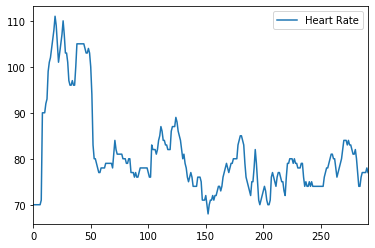

In [11]:
heartdf.plot()